# Directed GraphSage Model using StellarGraph Library

Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 [cs.SI], 2017.

Based on the open source: https://stellargraph.readthedocs.io/en/stable/demos/node-classification/directed-graphsage-node-classification.html

This example shows the application of *directed* GraphSAGE to a *directed* graph, where the in-node and out-node neighbourhoods are separately sampled and have different weights.

Import stellargraph:

In [86]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.2.1

In [87]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [88]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import sklearn
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

from stellargraph import StellarGraph
import json
from networkx.readwrite import json_graph
import networkx as nx
import numpy as np
from collections import Counter
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from utils import *

In [89]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Prepare the data

### Read the AML simulated transaction data

In [90]:
data_path = './data_small_graph/'
combined_directed_G = load_networkx_graphs(data_path)

1000_Network_p_0.002_w_0.003.json  - max_node_id= -1
1000_Network_p_0.002_w_0.008.json  - max_node_id= 999
1000_Network_p_0.002_w_0.009.json  - max_node_id= 1999
1000_Network_p_0.004_w_0.004.json  - max_node_id= 2999
1000_Network_p_0.004_w_0.007.json  - max_node_id= 3999
1000_Network_p_0.004_w_0.009.json  - max_node_id= 4999
1000_Network_p_0.005_w_0.009.json  - max_node_id= 5999
1000_Network_p_0.006_w_0.007.json  - max_node_id= 6999
1000_Network_p_0.007_w_0.002.json  - max_node_id= 7999
1000_Network_p_0.007_w_0.009.json  - max_node_id= 8999
1000_Network_p_0.007_w_0.010.json  - max_node_id= 9999
1000_Network_p_0.008_w_0.000.json  - max_node_id= 10999
1000_Network_p_0.008_w_0.005.json  - max_node_id= 11999
1000_Network_p_0.008_w_0.007.json  - max_node_id= 12999
1000_Network_p_0.010_w_0.001.json  - max_node_id= 13999
1000_Network_p_0.010_w_0.006.json  - max_node_id= 14999
1000_Network_p_0.011_w_0.003.json  - max_node_id= 15999
1000_Network_p_0.011_w_0.005.json  - max_node_id= 16999
1000_N

In [91]:
def generate_stellar_graph(combined_directed_G):
    node_feature_df, node_type_labels, _ = retrieve_node_features_and_labels_tuple(combined_directed_G)
    graph_feature = {i: [edge[2]['weight'] for edge in list(combined_directed_G.out_edges(i, data=True))] for i in list(combined_directed_G.nodes)}
    # max_features = max([len(node_feature) for node_feature in graph_feature.values()])    
    max_features = 150 # use fix feature numbers to runable and consistant on every graphs
    for key, value in graph_feature.items():
        if len(value) > max_features:
            graph_feature[key] = value[0: max_features]
        else:
            graph_feature[key].extend([0] * (max_features - len(value)))
    
    networkx_G = nx.DiGraph()
    networkx_G.add_edges_from(combined_directed_G.edges(data=True))
    nx.set_node_attributes(
        networkx_G,
        graph_feature,
        "feature",
    )

    G = StellarGraph.from_networkx(networkx_G, node_features="feature",
                                   node_type_default="account", edge_type_default="transaction")
    return G, node_type_labels, node_feature_df

In [92]:
G, node_subjects, node_features = generate_stellar_graph(combined_directed_G)

In [93]:
X = node_features
Y = node_subjects

In [94]:
print(G.info())

StellarDiGraph: Directed multigraph
 Nodes: 44000, Edges: 1384756

 Node types:
  account: [44000]
    Features: float32 vector, length 150
    Edge types: account-transaction->account

 Edge types:
    account-transaction->account: [1384756]
        Weights: range=[1.97201e-07, 1], mean=0.506063, std=0.291919
        Features: none


### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this

In [95]:
train_subjects, val_subjects = train_test_split(node_subjects, test_size=0.2)
train_subjects, test_subjects = train_test_split(train_subjects, test_size=0.2)

Note using stratified sampling gives the following counts:

In [96]:
neg, pos = np.bincount(train_subjects)
total = neg + pos
print('Examples:\n    Train: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Train: 28160
    Positive: 3912 (13.89% of total)



In [97]:
neg, pos = np.bincount(val_subjects)
total = neg + pos
print('Examples:\n    Valuation: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Valuation: 8800
    Positive: 1287 (14.62% of total)



In [98]:
neg, pos = np.bincount(test_subjects)
total = neg + pos
print('Examples:\n    Test: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Test: 7040
    Positive: 1015 (14.42% of total)



In [99]:
neg, pos = np.bincount(node_subjects)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 44000
    Positive: 6214 (14.12% of total)



The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [100]:
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

## Creating the GraphSAGE model in Keras

To feed data from the graph to the Keras model we need a data generator that feeds data from the graph to the model. The generators are specialized to the model and the learning task so we choose the `DirectedGraphSAGENodeGenerator` as we are predicting node attributes with a `DirectedGraphSAGE` model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer (5 in-nodes and 5 out-nodes), and 4 in the second layer (2 in-nodes and 2 out-nodes).

In [101]:
batch_size = 50 # default = 50
in_samples = [5, 2] # 5 in-directed edges in 1st layer, 2 in 2nd layer
out_samples = [5, 2] # 5 out-directed edge in 1st layer, 2 in 2nd layer

A `DirectedGraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [102]:
generator = DirectedGraphSAGENodeGenerator(G, batch_size, in_samples, out_samples)

Using the `generator.flow()` method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [103]:
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer, which corresponds to 12 weights for each head node, 10 for each in-node and 10 for each out-node.
 * The `bias` and `dropout` are internal parameters of the model. 

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

Now we create a model to predict the 7 categories using Keras softmax layers.

In [104]:
import tensorflow as tf
from tensorflow import keras
from stellargraph.layer import MaxPoolingAggregator

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)

    graphsage_model = DirectedGraphSAGE(
        # original [32, 32]
        layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5,
    )    
    
    x_inp, x_out = graphsage_model.in_out_tensors()
    prediction = layers.Dense(units=train_targets.shape[1], activation="sigmoid", bias_initializer=output_bias)(x_out)

    model = Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=optimizers.Adam(lr=1e-3),
        loss=losses.BinaryCrossentropy(),
        metrics=metrics,
    )

    return model

In [105]:
EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

initial_bias = np.log([pos/neg])
initial_bias

model = make_model(output_bias = initial_bias)
# model.predict(train_features[:10])

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)
# weighted_model.load_weights(initial_weights)

val_gen = generator.flow(val_subjects.index, val_targets)
test_gen = generator.flow(test_subjects.index, test_targets)

In [107]:
history = model.fit(
    train_gen,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    shuffle=False, 
    validation_data=val_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 564 steps, validate for 176 steps
Epoch 1/100
564/564 [==============================] - 35s 63ms/step - loss: 0.4025 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24248.0000 - fn: 3912.0000 - accuracy: 0.8611 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5326 - val_loss: 0.4133 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7513.0000 - val_fn: 1287.0000 - val_accuracy: 0.8537 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5751
Epoch 2/100
564/564 [==============================] - 32s 57ms/step - loss: 0.3998 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24248.0000 - fn: 3912.0000 - accuracy: 0.8611 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5671 - val_loss: 0.4110 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 7513.0000 - val_fn: 1287.0000 - val_accuracy: 0.8537 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5954tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 24022.0000 - fn: 3878

564/564 [==============================] - 34s 60ms/step - loss: 0.3847 - tp: 16.0000 - fp: 1.0000 - tn: 24247.0000 - fn: 3896.0000 - accuracy: 0.8616 - precision: 0.9412 - recall: 0.0041 - auc: 0.6417 - val_loss: 0.4034 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 7513.0000 - val_fn: 1286.0000 - val_accuracy: 0.8539 - val_precision: 1.0000 - val_recall: 7.7700e-04 - val_auc: 0.6499: 6.0000 -  - ETA: 7s - loss: 0.3880 - tp: 10.0000 - fp: 0.0000e+00 - tn: 17231.0000 - fn: 2809.0000 - accuracy: 0.8599 - precision: 1.0000 - recall: 0.0035 - auc: - ETA: 6s - loss: 0.3870 - tp: 11.0000 - fp: 0.0000e+00 - tn: 17755.0000 - fn: 2884.0000 - accuracy: 0.8603 - prec - ETA: 3s - loss: 0.3852 - tp: 12.0000 - fp: 0.0000e+00 - tn: 20837.0000 - fn: 3351.0000 - accuracy: 0.8615 
Epoch 13/100
564/564 [==============================] - 34s 60ms/step - loss: 0.3850 - tp: 30.0000 - fp: 1.0000 - tn: 24247.0000 - fn: 3882.0000 - accuracy: 0.8621 - precision: 0.9677 - recall: 0.0077 - auc: 0.6383 - val_los

564/564 [==============================] - 34s 61ms/step - loss: 0.3803 - tp: 161.0000 - fp: 37.0000 - tn: 24211.0000 - fn: 3751.0000 - accuracy: 0.8655 - precision: 0.8131 - recall: 0.0412 - auc: 0.6510 - val_loss: 0.3992 - val_tp: 30.0000 - val_fp: 0.0000e+00 - val_tn: 7513.0000 - val_fn: 1257.0000 - val_accuracy: 0.8572 - val_precision: 1.0000 - val_recall: 0.0233 - val_auc: 0.6499.0000 - accuracy: 0.8637 - precisi - ETA: 8s - loss: 0.3845 - tp: 106.0000 - fp: 25.0000 - tn: 16158.0000 - fn: 2561.0000 - accuracy: 0.8628 - precision: 0.8092 - recall: 0.03 - ETA: 7s - loss: 0.3822 - tp: 116.0000 - fp: 26.0000 - tn: 17381.0000 - fn: 2727.0000 - accuracy: 0.8640 - precision: 0 - ETA: 4s - loss: 0.3804 - tp: 130.0000 - fp: 29.0000 - tn: 19948.0000 - fn: 3093.0000 - accuracy: 0.8654 - prec - ETA: 1s - loss: 0.3810 - tp: 151.0000 - fp: 32.0000 - tn: 22947.0000 - fn: 3570.0000 - accuracy: 0.8651 - precision: 0.8251 - recall: 0
Epoch 25/100
564/564 [==============================] - 34s 61ms/

564/564 [==============================] - 34s 61ms/step - loss: 0.3783 - tp: 192.0000 - fp: 35.0000 - tn: 24213.0000 - fn: 3720.0000 - accuracy: 0.8667 - precision: 0.8458 - recall: 0.0491 - auc: 0.6506 - val_loss: 0.3970 - val_tp: 42.0000 - val_fp: 0.0000e+00 - val_tn: 7513.0000 - val_fn: 1245.0000 - val_accuracy: 0.8585 - val_precision: 1.0000 - val_recall: 0.0326 - val_auc: 0.6534
Epoch 00033: early stopping


Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [108]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()


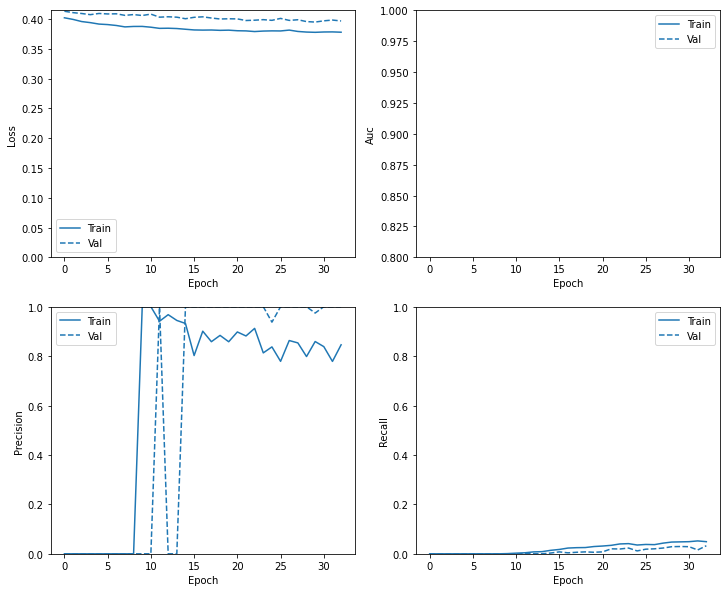

In [109]:
plot_metrics(history)

Now we have trained the model we can evaluate on the test set.

### Evaluate metrics

You can use a [confusion matrix](https://developers.google.com/machine-learning/glossary/#confusion_matrix) to summarize the actual vs. predicted labels where the X axis is the predicted label and the Y axis is the actual label.

In [110]:
train_predictions_baseline = model.predict(train_gen)
test_predictions_baseline = model.predict(test_gen)

In [111]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

In [112]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
141/141 [==============================] - 6s 40ms/step - loss: 0.3919 - tp: 18.0000 - fp: 0.0000e+00 - tn: 6025.0000 - fn: 997.0000 - accuracy: 0.8584 - precision: 1.0000 - recall: 0.0177 - auc: 0.6696: 0s - loss: 0.3962 - tp: 14.0000 - fp: 0.0000e+00 - tn: 5382.0000 - fn: 904.0000 - accuracy: 0.8565 - precision: 1.0000 - recall: 0.0153 - au

Test Set Metrics:
	loss: 0.3919
	tp: 18.0000
	fp: 0.0000
	tn: 6025.0000
	fn: 997.0000
	accuracy: 0.8584
	precision: 1.0000
	recall: 0.0177
	auc: 0.6696


In [113]:
print(confusion_matrix(test_subjects, test_predictions_baseline > 0.5))
print(classification_report(test_subjects, test_predictions_baseline > 0.5))

[[6025    0]
 [ 993   22]]
              precision    recall  f1-score   support

           0       0.86      1.00      0.92      6025
           1       1.00      0.02      0.04      1015

    accuracy                           0.86      7040
   macro avg       0.93      0.51      0.48      7040
weighted avg       0.88      0.86      0.80      7040



Legitimate Transactions Detected (True Negatives):  6025
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  993
Fraudulent Transactions Detected (True Positives):  22
Total Fraudulent Transactions:  1015


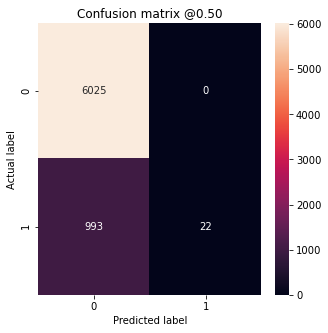

In [114]:
plot_cm(test_subjects, test_predictions_baseline)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [115]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

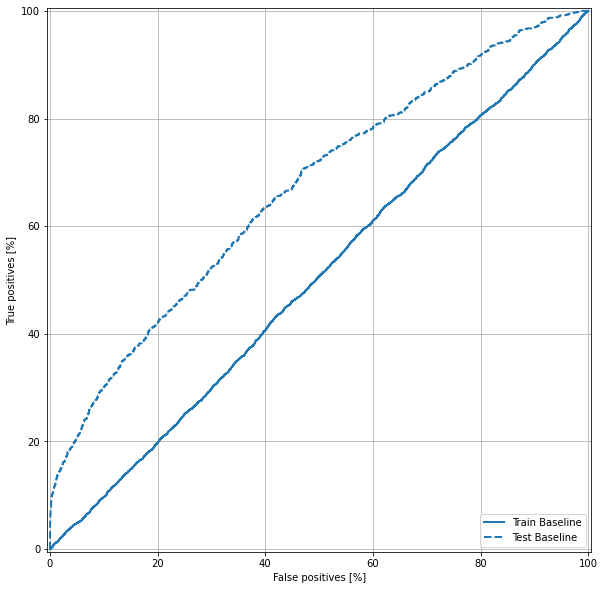

In [116]:
plot_roc("Train Baseline", train_subjects, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_subjects, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

### Save this model

In [117]:
# Save model
filename = 'models/keras_graphsage/no_weight_model_highprecision_lowrecall'
model.save(filename)

INFO:tensorflow:Assets written to: models/keras_graphsage/no_weight_model_highprecision_lowrecall\assets


In [118]:
keras_graphsage_model = keras.models.load_model('models/keras_graphsage/no_weight_model_highprecision_lowrecall')

Legitimate Transactions Detected (True Negatives):  6025
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  995
Fraudulent Transactions Detected (True Positives):  20
Total Fraudulent Transactions:  1015


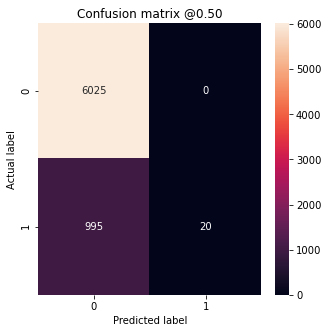

In [119]:
evaluation_predictions_baseline = keras_graphsage_model.predict(test_gen)
plot_cm(test_subjects, evaluation_predictions_baseline)

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

### Class weights

In [120]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.58
Weight for class 1: 3.54


In [121]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_gen,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=val_gen,
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 564 steps, validate for 176 steps
Epoch 1/100
564/564 [==============================] - 39s 69ms/step - loss: 0.7102 - tp: 763.0000 - fp: 4754.0000 - tn: 19494.0000 - fn: 3149.0000 - accuracy: 0.7194 - precision: 0.1383 - recall: 0.1950 - auc: 0.4975 - val_loss: 0.7021 - val_tp: 1279.0000 - val_fp: 7450.0000 - val_tn: 63.0000 - val_fn: 8.0000 - val_accuracy: 0.1525 - val_precision: 0.1465 - val_recall: 0.9938 - val_auc: 0.552276.0000 - fn: 1988.0000 - accuracy: 0.8503 - -
Epoch 2/100
564/564 [==============================] - 33s 59ms/step - loss: 0.6880 - tp: 1553.0000 - fp: 8903.0000 - tn: 15345.0000 - fn: 2359.0000 - accuracy: 0.6001 - precision: 0.1485 - recall: 0.3970 - auc: 0.5221 - val_loss: 0.6997 - val_tp: 1259.0000 - val_fp: 7203.0000 - val_tn: 310.0000 - val_fn: 28.0000 - val_accuracy: 0.1783 - val_precision: 0.1488 - val_recall: 0.9782 - val_auc: 0.5764
Epoch 3/100
564/564 [==============================] - 34s 60

564/564 [==============================] - 32s 57ms/step - loss: 0.6561 - tp: 2121.0000 - fp: 8541.0000 - tn: 15707.0000 - fn: 1791.0000 - accuracy: 0.6331 - precision: 0.1989 - recall: 0.5422 - auc: 0.6381 - val_loss: 0.6635 - val_tp: 620.0000 - val_fp: 2012.0000 - val_tn: 5501.0000 - val_fn: 667.0000 - val_accuracy: 0.6956 - val_precision: 0.2356 - val_recall: 0.4817 - val_auc: 0.6561 precision: 0.2025 - recall:  - ETA: 16s - loss: 0.6560 - tp: 604.0000 - fp: 2465.0000 - tn: 4551.0000 - fn: 530.0000 - accuracy: 0.6325 - precision: 0.1968 - recall: 0.5326 - auc: 0. - ETA: 16s - loss: - ETA: 4s - loss: 0.6587 - tp: 1778.0000 
Epoch 16/100
564/564 [==============================] - 32s 57ms/step - loss: 0.6526 - tp: 2165.0000 - fp: 8441.0000 - tn: 15807.0000 - fn: 1747.0000 - accuracy: 0.6382 - precision: 0.2041 - recall: 0.5534 - auc: 0.6437 - val_loss: 0.6637 - val_tp: 700.0000 - val_fp: 2332.0000 - val_tn: 5181.0000 - val_fn: 587.0000 - val_accuracy: 0.6683 - val_precision: 0.2309 - 

564/564 [==============================] - 35s 61ms/step - loss: 0.6451 - tp: 2184.0000 - fp: 8084.0000 - tn: 16164.0000 - fn: 1728.0000 - accuracy: 0.6516 - precision: 0.2127 - recall: 0.5583 - auc: 0.6577 - val_loss: 0.6622 - val_tp: 535.0000 - val_fp: 1443.0000 - val_tn: 6070.0000 - val_fn: 752.0000 - val_accuracy: 0.7506 - val_precision: 0.2705 - val_recall: 0.4157 - val_auc: 0.6629accuracy: 0.6585 - precision: 0.2168 - recall: 0.5625 - auc - ETA: 17s - loss: 0.6423 - tp: 665.0000 - fp: 2384.0000 - tn: 4842.0000 - fn: 509.0000 - accuracy: 0.6556 - precision: 0.2181 - recall - ETA: 16s - loss: 0 - ETA: 10s - - ETA: 4s - loss: 0.6473 - tp: 1855.0000 - fp: 68
Epoch 29/100
564/564 [==============================] - 34s 61ms/step - loss: 0.6478 - tp: 2151.0000 - fp: 8156.0000 - tn: 16092.0000 - fn: 1761.0000 - accuracy: 0.6478 - precision: 0.2087 - recall: 0.5498 - auc: 0.6514 - val_loss: 0.6789 - val_tp: 443.0000 - val_fp: 1123.0000 - val_tn: 6390.0000 - val_fn: 844.0000 - val_accuracy

### Check training history

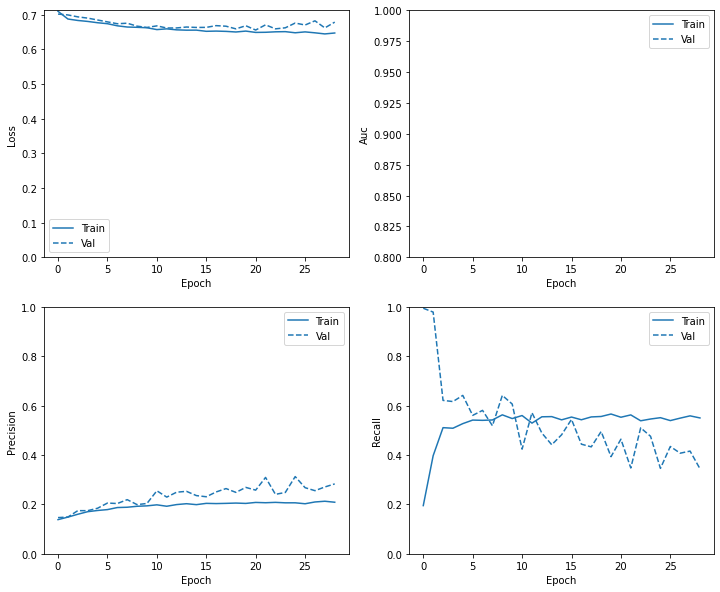

In [122]:
plot_metrics(weighted_history)

### Evaluate metrics

In [123]:
train_predictions_weighted = weighted_model.predict(train_gen)
test_predictions_weighted = weighted_model.predict(test_gen)

In [124]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

Evaluate your model on the test dataset and display the results for the metrics you created above.

In [125]:
test_metrics = weighted_model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(weighted_model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

  ...
    to  
  ['...']
141/141 [==============================] - 7s 53ms/step - loss: 0.5969 - tp: 503.0000 - fp: 1604.0000 - tn: 4421.0000 - fn: 512.0000 - accuracy: 0.6994 - precision: 0.2387 - recall: 0.4956 - auc: 0.67203s - loss: 0.5956 - tp: 295.0000 - fp: 966.0000 - tn: 2592.0000 - fn: 297.0000 - accuracy: 0.6957 - precision: 0.2339 - recall: 0.4983 - auc: 0 - ETA: 3s - loss: 0.5959 - tp: 323.0000 - fp: 1037.0000 - tn: 2776.0000 - fn: 314.0000 - accuracy: 0.6964 - precision: 0.2375 - recall: 0.5071 - auc: 0.680 - ETA: 2s - loss: 0.5962 - tp: 328.0000 - fp: 1063.0000 - tn: 2838.0000 - fn: 321.0000 - accuracy: 0.6958 - precision: 0.2358 - recall: 0.505 - ETA: 1s - loss: 0.5969 - tp: 426.0000 - fp: 1363.0000 - tn: 3728.0000 - fn: 433.0000 - accuracy: 0.6982 - precision: 0.2381 - recall: 0.4959 -

Test Set Metrics:
	loss: 0.5969
	tp: 503.0000
	fp: 1604.0000
	tn: 4421.0000
	fn: 512.0000
	accuracy: 0.6994
	precision: 0.2387
	recall: 0.4956
	auc: 0.6720


In [126]:
print(confusion_matrix(test_subjects, test_predictions_weighted > 0.5))
print(classification_report(test_subjects, test_predictions_weighted > 0.5))

[[4425 1600]
 [ 508  507]]
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      6025
           1       0.24      0.50      0.32      1015

    accuracy                           0.70      7040
   macro avg       0.57      0.62      0.57      7040
weighted avg       0.80      0.70      0.74      7040



Legitimate Transactions Detected (True Negatives):  4425
Legitimate Transactions Incorrectly Detected (False Positives):  1600
Fraudulent Transactions Missed (False Negatives):  508
Fraudulent Transactions Detected (True Positives):  507
Total Fraudulent Transactions:  1015


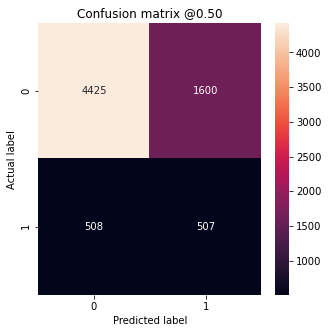

In [127]:
plot_cm(test_subjects, test_predictions_weighted)

If the model had predicted everything perfectly, this would be a [diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix) where values off the main diagonal, indicating incorrect predictions, would be zero. In this case the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged. However, you would likely want to have even fewer false negatives despite the cost of increasing the number of false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

### Plot the ROC

Now plot the [ROC](https://developers.google.com/machine-learning/glossary#ROC). This plot is useful because it shows, at a glance, the range of performance the model can reach just by tuning the output threshold.

In [128]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100.5])
  plt.ylim([-0.5,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

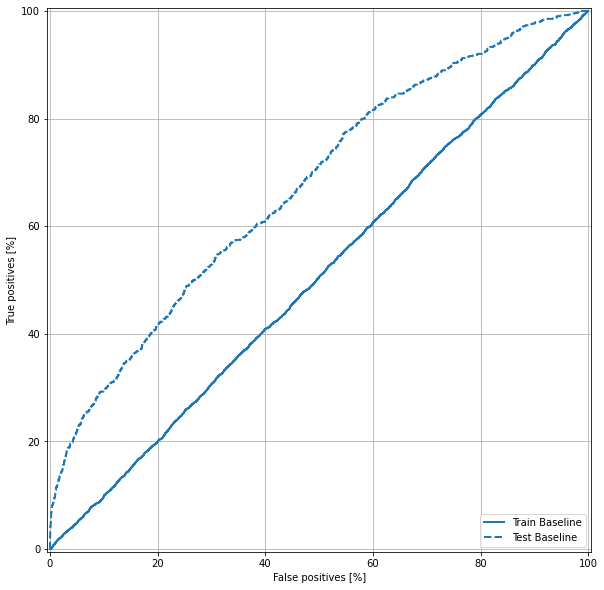

In [129]:
plot_roc("Train Baseline", train_subjects, train_predictions_weighted, color=colors[0])
plot_roc("Test Baseline", test_subjects, test_predictions_weighted, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

### Save this model

In [130]:
# Save model
filename = 'models/keras_graphsage/weighted_model_lowprecision_highrecall'
weighted_model.save(filename)

INFO:tensorflow:Assets written to: models/keras_graphsage/weighted_model_lowprecision_highrecall\assets


In [79]:
keras_graphsage_weighted_model = keras.models.load_model('models/keras_graphsage/weighted_model_lowprecision_highrecall')

Legitimate Transactions Detected (True Negatives):  4717
Legitimate Transactions Incorrectly Detected (False Positives):  1299
Fraudulent Transactions Missed (False Negatives):  587
Fraudulent Transactions Detected (True Positives):  437
Total Fraudulent Transactions:  1024


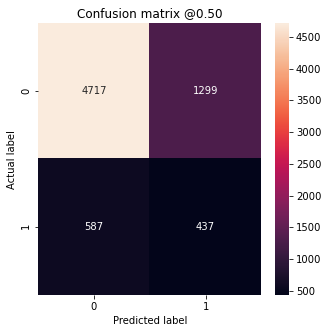

In [80]:
evaluation_predictions_baseline = keras_graphsage_weighted_model.predict(test_gen)
plot_cm(test_subjects, evaluation_predictions_baseline)

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/node-classification/directed-graphsage-node-classification.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/node-classification/directed-graphsage-node-classification.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>